In [28]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style='white')
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from urllib.parse import urlencode, quote_plus
# https://stackoverflow.com/questions/40557606/how-to-url-encode-in-python-3
from bs4 import BeautifulSoup
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

fontproperties = FontProperties(fname = 'font_ch.ttf', size = 14)
font = 'font_ch.ttf'



### SERP Crawler

SERP features:
- 精選摘要出現數量
    - `<div class="kp-blk c2xzTb Wnoohf OJXvsb">`
- 關鍵字廣告出現數量
    - `<div class="qGXjvb">`
- Google Map 公司出現數量
    - `<div class="AEprdc vk_c">`

Article features:
- 標題
- 標題包含幾次當前的搜尋關鍵字
- 標題下方是否出現小字
    - `<div class="jYOxx">`
- 標題下方是否出現評價資訊
    - `<div class="fG8Fp f">`
    - schema: "aggregateRating"
- 標題下方是否出現問答格式
    - `<div class="rTylWd">`

> BeautifulSoup selector:
https://www.itread01.com/content/1536692545.html


#### SERP features

In [3]:
base_url = 'https://www.google.com/search?'
search_keyword = 'seo 公司'
num = 50
produce_date = 200922
headers = {
    'content-type': 'text/html; charset=UTF-8',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36'
}

params = {'q': search_keyword, 'num': num}
target_url = base_url + urlencode(params, quote_via=quote_plus)
print(target_url)


https://www.google.com/search?q=seo+%E5%85%AC%E5%8F%B8&num=50


In [21]:
collect = list()

html = requests.get(target_url, headers=headers, timeout=15).content
soup = BeautifulSoup(html, 'html.parser')
# print(soup.prettify())

def check_elem(crawl_content, tag_name, class_name):
    soup = crawl_content
    try:
        num_gFeatures = len(soup.find_all(tag_name, class_=class_name))
    except:
        num_gFeatures = 0
    
    return num_gFeatures

num_gFeatures = check_elem(soup, tag_name='div', class_name='kp-blk c2xzTb Wnoohf OJXvsb')
num_kwAds = check_elem(soup, tag_name='div', class_name='qGXjvb')
num_gMap = check_elem(soup, tag_name='div', class_name='AEprdc vk_c')


for block in soup.find_all('div', class_='g'):
    title = block.h3.text
    desc = block.find('span', class_='st').text
    link = block.find('a').attrs['href']
    num_articleSnippet = check_elem(block, tag_name='div', class_name='jYOxx')
    num_review = check_elem(block, tag_name='div', class_name='fG8Fp f')
    num_collapseQA = check_elem(block, tag_name='div', class_name='rTylWd')

    collect.append([title, desc, link, num_articleSnippet, num_review, num_collapseQA])

df = pd.DataFrame(collect, columns=['title', 'desc', 'link', 'num_articleSnippet', 'num_review', 'num_collapseQA'])
print(df.shape)
df.head()



(50, 6)


,title,desc,link,num_articleSnippet,num_review,num_collapseQA
0,SEO收費行情？該怎麼選擇SEO公司?-SEO優化-部落格-達文西 ...,2020年3月17日 - 大家都在討論SEO關鍵字排名，市場報價非常紊亂，比網頁設計更沒有報...,https://www.da-vinci.com.tw/tw/blog/seo-cost,0,0,0
1,【SEO關鍵字公司】SEO公司怎麼選？看這篇推薦最適合你的 ...,一個合格的SEO公司能為你服務的，而不是只是單純的排名與成效收費，傳統類型的SEO 公司更重...,https://inboundmarketing.com.tw/seo/seo%E5%85%...,0,0,0
2,SEO 公司怎麼選才有效？搞懂SEO 公司服務類型、收費以及 ...,2020年7月28日 - 想做SEO 的品牌，無非是想要獲得更多「自然搜尋流量」，讓更多潛在...,https://growthmarketing.tw/seo%E5%84%AA%E5%8C%...,1,0,0
3,【SEO觀念7】SEO 公司挑選指南：認識SEO 顧問與優化服務 ...,2019年8月18日 - 不同階段的企業可以藉由SEO 達到什麼樣的效益、服務有哪些形式以及...,https://ranking.works/SEO%E6%95%99%E5%AD%B8/SE...,0,0,0
4,行銷人必讀，找SEO顧問前你該知道的事| Harris先生,以SEO顧問公司來說，即便顧問公司的顧問有行銷專業、網站分析專業、廣告投放的專業，你跑去問他...,https://www.yesharris.com/before-seo-agency/,0,0,0


In [25]:
num_gFeatures
num_kwAds
num_gMap


0

0

1

In [7]:
df.to_csv('SERP_{}_num_{}_{}.csv'.format(search_keyword, num, produce_date), index=False)


#### 特定欄位包含搜尋詞 與排名次序的相關性

結論：(詳看下2 相關度矩陣)
> 注：相關度會負數是因為本資料集中以排名為標的，而排名的數值越小越好

- title: 標題中是否包含『seo』 與排名的相關性最高(0.38)
- desc: 描述中是否包含『seo』 與排名的相關性最高(0.5)、其次是包含『公司』(0.3)
- link: 網址中是否包含搜尋詞與排名的相關性偏低 (<0.12)


In [5]:
df = pd.read_csv('SERP_{}_num_{}_{}.csv'.format(search_keyword, num, produce_date))

In [6]:
specific_cols = ['title','desc','link']
exam_kw_in_cols = ['seo','公司','seo公司']

for specific_col in specific_cols:
    df[specific_col] = df[specific_col].apply(lambda x: x.lower())
    for exam_kw in exam_kw_in_cols:
        df[f'{specific_col}_contains_{exam_kw}'] = df[specific_col].apply(lambda x: x.count(str(exam_kw)))
    
df.head()


,title,desc,link,num_articleSnippet,num_review,num_collapseQA,title_contains_seo,title_contains_公司,title_contains_seo公司,desc_contains_seo,desc_contains_公司,desc_contains_seo公司,link_contains_seo,link_contains_公司,link_contains_seo公司
0,seo收費行情？該怎麼選擇seo公司?-seo優化-部落格-達文西 ...,2020年3月17日 - 大家都在討論seo關鍵字排名，市場報價非常紊亂，比網頁設計更沒有報...,https://www.da-vinci.com.tw/tw/blog/seo-cost,0,0,0,3,1,1,4,1,1,1,0,0
1,【seo關鍵字公司】seo公司怎麼選？看這篇推薦最適合你的 ...,一個合格的seo公司能為你服務的，而不是只是單純的排名與成效收費，傳統類型的seo 公司更重...,https://inboundmarketing.com.tw/seo/seo%e5%85%...,0,0,0,2,2,1,3,2,1,2,0,0
2,seo 公司怎麼選才有效？搞懂seo 公司服務類型、收費以及 ...,2020年7月28日 - 想做seo 的品牌，無非是想要獲得更多「自然搜尋流量」，讓更多潛在...,https://growthmarketing.tw/seo%e5%84%aa%e5%8c%...,1,0,0,2,2,0,2,1,0,1,0,0
3,【seo觀念7】seo 公司挑選指南：認識seo 顧問與優化服務 ...,2019年8月18日 - 不同階段的企業可以藉由seo 達到什麼樣的效益、服務有哪些形式以及...,https://ranking.works/seo%e6%95%99%e5%ad%b8/se...,0,0,0,3,1,0,4,1,0,2,0,0
4,行銷人必讀，找seo顧問前你該知道的事| harris先生,以seo顧問公司來說，即便顧問公司的顧問有行銷專業、網站分析專業、廣告投放的專業，你跑去問他...,https://www.yesharris.com/before-seo-agency/,0,0,0,1,0,0,1,2,0,1,0,0


In [36]:
df['rank'] = df.index
df_target = df.iloc[:, 3:df.shape[1]]
corr = df_target.corr()
corr = corr.fillna(0.0)
corr
corr[['rank']]



,num_articleSnippet,num_review,num_collapseQA,title_contains_seo,title_contains_公司,title_contains_seo公司,desc_contains_seo,desc_contains_公司,desc_contains_seo公司,link_contains_seo,link_contains_公司,link_contains_seo公司,rank
num_articleSnippet,1.000000e+00,-0.020408,0.0,0.094609,0.245833,-0.090070,-1.907701e-18,-0.013283,-0.117454,0.020408,0.0,0.0,-0.222737
num_review,-2.040816e-02,1.000000,0.0,0.283828,0.033908,0.191398,-1.374643e-01,-0.234667,-0.117454,0.020408,0.0,0.0,0.133642
num_collapseQA,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000
title_contains_seo,9.460945e-02,0.283828,0.0,1.000000,0.275088,0.417551,3.313783e-01,-0.184735,-0.049500,0.321672,0.0,0.0,-0.382742
title_contains_公司,2.458333e-01,0.033908,0.0,0.275088,1.000000,0.500394,3.425944e-01,0.160005,0.195149,0.220402,0.0,0.0,-0.238493
title_contains_seo公司,-9.006976e-02,0.191398,0.0,0.417551,0.500394,1.000000,3.033438e-01,0.124575,0.512483,0.146363,0.0,0.0,-0.292179
desc_contains_seo,-1.907701e-18,-0.137464,0.0,0.331378,0.342594,0.303344,1.000000e+00,0.328062,0.395571,0.054986,0.0,0.0,-0.549443
desc_contains_公司,-1.328305e-02,-0.234667,0.0,-0.184735,0.160005,0.124575,3.280616e-01,1.000000,0.444784,0.013283,0.0,0.0,-0.303906
desc_contains_seo公司,-1.174541e-01,-0.117454,0.0,-0.049500,0.195149,0.512483,3.955709e-01,0.444784,1.000000,0.064066,0.0,0.0,-0.160562
link_contains_seo,2.040816e-02,0.020408,0.0,0.321672,0.220402,0.146363,5.498574e-02,0.013283,0.064066,1.000000,0.0,0.0,-0.111863


,rank
num_articleSnippet,-0.222737
num_review,0.133642
num_collapseQA,0.000000
title_contains_seo,-0.382742
title_contains_公司,-0.238493
title_contains_seo公司,-0.292179
desc_contains_seo,-0.549443
desc_contains_公司,-0.303906
desc_contains_seo公司,-0.160562
link_contains_seo,-0.111863


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 <a list of 13 Text major ticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 <a list of 13 Text major ticklabel objects>)

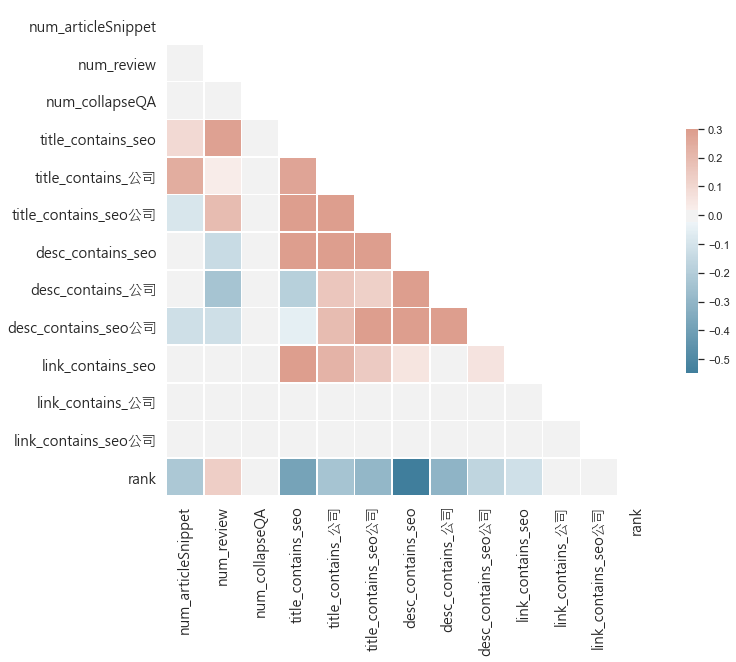

In [30]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontproperties=fontproperties)
plt.yticks(fontproperties=fontproperties)



#### 語意是否因排名順序有群聚
- title
- desc
- link

(參照 notebook: [`extract-important-keywords+tfidf+word2vec+PCA`](http://localhost:8888/notebooks/SEOxML/extract-important-keywords%2Btfidf%2Bword2vec%2BPCA.ipynb))